In [34]:
# Imports
# pip install kagglehub[pandas-datasets]
#import kagglehub
#from kagglehub import KaggleDatasetAdapter
import os
import random
from glob import glob
import cv2 
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import numpy as np


import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import classification_report

import argparse
#import torch
#import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from collections import Counter

# DATA

In [35]:
class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx].astype(np.uint8)
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Load the data(images)
x_npz = np.load("../../data/x_images_arrays.npz")
X = x_npz["arr_0"]
y_npz = np.load("../../data/y_labels_arrays.npz")
Y = y_npz["arr_0"]

print("x = ", np.array(X).shape)
print("Y = ", np.array(Y).shape)

# Separete the data into train and test sets
# 80% train, 20% test
x_train_old, x_test, y_train_old, y_test = train_test_split(X, Y, test_size=0.2,random_state=1, stratify=Y)

x_train_aux = np.load("../../data/x_images_arrays_under_train_over.npz")
x_train = x_train_aux["arr_0"]
y_train_aux = np.load("../../data/y_labels_arrays_under_train_over.npz")
y_train = y_train_aux["arr_0"]

#x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp)

print("\nForma dos dados de treino:", np.array(x_train).shape) # (3045, 128, 128, 3)
print("Distribuição train antes:", Counter(y_train)) #np.int64(0): 2435, np.int64(2): 402, np.int64(1): 208
#print(np.array(x_val).shape)
print("Forma dos dados de teste:", np.array(x_test).shape) # (762, 128, 128, 3)
print("Distribuição test antes:", Counter(y_test)) #np.int64(0): 609, np.int64(2): 101, np.int64(1): 52

# Transform the data to tensor
# Define a transform
transform = transforms.Compose([
            #transforms.Resize((28, 28)),
            transforms.ToPILImage(),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

# Apply the transform to the data
dataset_train = CustomImageDataset(x_train, y_train, transform=transform)
#dataset_val = CustomImageDataset(x_val, y_val, transform=transform)
dataset_test = CustomImageDataset(x_test, y_test, transform=transform)

img, label = dataset_train[0]
print("\nForma do img e label:", img.shape, label) # [grayscale=1, size=128, size=128] label=0 ('Nothing')
print("Quantidade dados de treino:", dataset_train.__len__()) # 610 images
#print(dataset_val.__len__()) # 0 images
print("Quantidade dados de teste:", dataset_test.__len__()) # 762 images

# Load into the DataLoader
batch_size = 32

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
#val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)


x =  (3807, 128, 128, 3)
Y =  (3807,)

Forma dos dados de treino: (1206, 128, 128, 3)
Distribuição train antes: Counter({np.int64(2): 402, np.int64(0): 402, np.int64(1): 402})
Forma dos dados de teste: (762, 128, 128, 3)
Distribuição test antes: Counter({np.int64(0): 609, np.int64(2): 101, np.int64(1): 52})

Forma do img e label: torch.Size([1, 128, 128]) 2
Quantidade dados de treino: 1206
Quantidade dados de teste: 762


# NETWORK

### Define

In [36]:
# Define the network

# Already defined in the previous cell
# batch_size = 32
# train_loader / val_loader / test_loader
num_steps = 50

dtype = torch.float
# Use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Network Architecture 
num_inputs = 128*128
num_hidden = 1000
num_outputs = 3 # classes

# Temporal Dynamics
# num_steps = 25
#beta = 0.95

# Define Network
class Net(nn.Module):
    def __init__(self): 
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        #self.relu2 = nn.ReLU()

    def forward(self, x):
        # Flatten input if necessary
        x = x.view(-1, num_inputs)
        
        # Forward pass through layers
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        #x = self.relu2(x) # tentar tirar
        #output = F.log_softmax(x, dim=1)  # Saída com log_softmax
        return x

# Load the network onto CUDA if available
net = Net().to(device)

In [56]:
# Metrics
# Accuracy
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output = net(data)
    _, idx = output.max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

# Função para calcular métricas
def calculate_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro') # average = 'weighted' | 'micro' | 'macro'
    return precision, recall, f1

# loss
# 1. Contar quantos exemplos de cada classe existem no dataset
# targets_list = []

# # Percorre todo o conjunto de treino para pegar os rótulos
# for _, targets in train_loader:
#     targets_list.extend(targets.tolist())

# class_counts = Counter(targets_list)
# total_samples = sum(class_counts.values())

# # 2. Calcular o peso inverso à frequência (quanto menos amostras, maior o peso)
# num_classes = len(class_counts)
# class_weights = []

# for i in range(num_classes):
#     count = class_counts[i]
#     weight = total_samples / (num_classes * count)
#     class_weights.append(weight)

# # 3. Criar tensor e mover para o mesmo dispositivo da rede
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# 4. Redefinir a função de perda com pesos
# loss = nn.CrossEntropyLoss(weight=class_weights)

# Total samples
# total = 402 + 208 + 402

# # Frequência relativa inversa
# w0 = total / (3 * 402)
# w1 = total / (3 * 208)
# w2 = total / (3 * 402)

# # Tensor com pesos
# weights = torch.tensor([w0, w1, w2], dtype=torch.float).to(device)

# # Loss ponderado
# loss = nn.CrossEntropyLoss(weight=weights)

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


# Class-Balanced Loss
beta = 0.95
class_counts = [402, 52, 101]
effective_num = [(1 - beta) / (1 - beta ** count) for count in class_counts]
weights = torch.tensor(effective_num, dtype=torch.float).to(device)
#loss = nn.CrossEntropyLoss(weight=weights)

loss = FocalLoss(alpha=weights, gamma=2.0)
#loss = nn.CrossEntropyLoss()  # Sem pesos, pois o dataset já está balanceado

# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

### Training Loop

In [57]:
PATH = '../../models/ann_full_32_under_class_weights_over.pth'

In [58]:
# Training loop
num_epochs = 50
loss_hist = []
test_loss_hist = []
counter = 0

# Early stopping parameters
best_f1 = 0
epochs_no_improve = 0
early_stop_patience = 10  # quantas épocas esperar sem melhoria


# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)
    
    # Minibatch training loop
    for data, targets in train_batch:
        #print(epoch, iter_counter, counter)
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        #spike_data = spikegen.latency(data, num_steps=num_steps, tau=1, threshold=0.001, clip=True, normalize=True, linear=True)
        #print(f"Spike data size (latency 2): {spike_data.size()}")

        output = net(data)

        # Calculate loss
        loss_val = loss(output, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_output = net(test_data)

            # Test set loss
            test_loss = loss(test_output, test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            #if counter % 32 == 0:
                #train_printer()
            counter += 1
            iter_counter += 1
    
    # Early stopping check
    net.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data_2, targets_2 in test_loader:
            data_2 = data_2.to(device)
            targets_2 = targets_2.to(device)

            test_output_2 = net(data_2)
            _, predicted_2 = test_output_2.max(1)

            all_preds.extend(predicted_2.cpu().numpy())
            all_targets.extend(targets_2.cpu().numpy())

    # Calcular F1-score para early stopping
    precision, recall, f1 = calculate_metrics(all_targets, all_preds)
    print(f"\n[Epoch {epoch+1}] F1-score: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

    # Early Stopping com base no F1-score
    if f1 > best_f1:
        best_f1 = f1
        epochs_no_improve = 0
        torch.save(net.state_dict(), PATH)
        print("🟢 Novo melhor modelo salvo!")
    else:
        epochs_no_improve += 1
        print(f"🔸 Sem melhoria. Épocas sem progresso: {epochs_no_improve}/{early_stop_patience}")

    if epochs_no_improve >= early_stop_patience:
        print(f"\n⛔ Early stopping ativado após {epoch+1} épocas. Melhor F1-score: {best_f1:.4f}")
        break



[Epoch 1] F1-score: 0.2900 | Precision: 0.3697 | Recall: 0.4009
🟢 Novo melhor modelo salvo!

[Epoch 2] F1-score: 0.2766 | Precision: 0.3745 | Recall: 0.3954
🔸 Sem melhoria. Épocas sem progresso: 1/10

[Epoch 3] F1-score: 0.3246 | Precision: 0.3764 | Recall: 0.4193
🟢 Novo melhor modelo salvo!

[Epoch 4] F1-score: 0.3555 | Precision: 0.3835 | Recall: 0.4296
🟢 Novo melhor modelo salvo!

[Epoch 5] F1-score: 0.3662 | Precision: 0.3736 | Recall: 0.4011
🟢 Novo melhor modelo salvo!

[Epoch 6] F1-score: 0.3415 | Precision: 0.3754 | Recall: 0.4193
🔸 Sem melhoria. Épocas sem progresso: 1/10

[Epoch 7] F1-score: 0.3398 | Precision: 0.3790 | Recall: 0.4193
🔸 Sem melhoria. Épocas sem progresso: 2/10

[Epoch 8] F1-score: 0.3485 | Precision: 0.3732 | Recall: 0.4127
🔸 Sem melhoria. Épocas sem progresso: 3/10

[Epoch 9] F1-score: 0.3728 | Precision: 0.3840 | Recall: 0.4229
🟢 Novo melhor modelo salvo!

[Epoch 10] F1-score: 0.3252 | Precision: 0.3712 | Recall: 0.4074
🔸 Sem melhoria. Épocas sem progresso:

In [ ]:
# Código extra para salvar o modelo
PATH = '../../models/ann_full_32_under_class_weights_over.pth'
torch.save(net.state_dict(), PATH)
print(f"Modelo salvo com sucesso em: {PATH}")

Modelo salvo com sucesso em: ../../models/ann_full_4_under.pth


In [59]:
# Carregar melhor modelo após o treinamento
net.load_state_dict(torch.load(PATH))
net.eval()

Net(
  (fc1): Linear(in_features=16384, out_features=1000, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1000, out_features=3, bias=True)
)

### Metrics

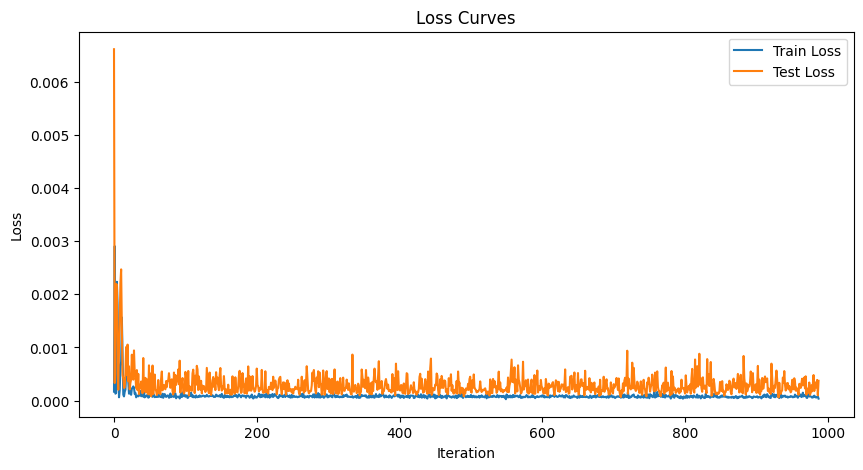

In [60]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [61]:
# Listas para armazenar previsões e rótulos verdadeiros
all_preds = []
all_targets = []

# Avaliação do modelo
total = 0
correct = 0

with torch.no_grad():
    net.eval()
    for data_3, targets_3 in test_loader:
        data_3 = data_3.to(device)
        targets_3 = targets_3.to(device)

        # Test set forward pass
        test_output_3 = net(data_3)

        # Previsões
        _, predicted_3 = test_output_3.max(1)
        
        # Acumular acurácia
        total += targets_3.size(0)
        correct += (predicted_3 == targets_3).sum().item()

        # Armazenar previsões e rótulos para F1 e matriz de confusão
        all_preds.extend(predicted_3.cpu().numpy())
        all_targets.extend(targets_3.cpu().numpy())

# Calcular acurácia
print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

# Calcular precisão, recall e F1-score
precision, recall, f1 = calculate_metrics(all_targets, all_preds) 
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

# Calcular e exibir a matriz de confusão
conf_matrix = confusion_matrix(all_targets, all_preds)
print("\nMatriz de Confusão:")
print(conf_matrix)

# Relatório detalhado por classe
print("\nClassification Report:")
print(classification_report(all_targets, all_preds, digits=4))

Total correctly classified test set images: 476/762
Test Set Accuracy: 62.47%
Precision: 0.39
Recall: 0.41
F1-score: 0.39

Matriz de Confusão:
[[433  68 108]
 [ 30  11  11]
 [ 62   7  32]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8248    0.7110    0.7637       609
           1     0.1279    0.2115    0.1594        52
           2     0.2119    0.3168    0.2540       101

    accuracy                         0.6247       762
   macro avg     0.3882    0.4131    0.3924       762
weighted avg     0.6960    0.6247    0.6549       762



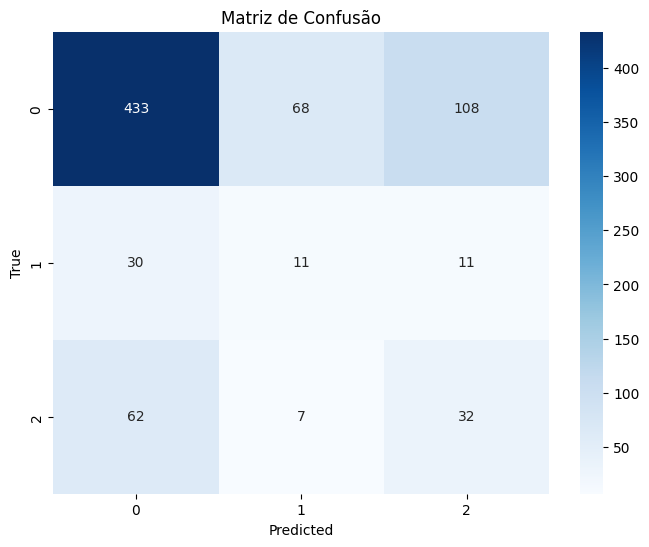

In [62]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão')
plt.show()